# Analysis of the HCP data model-fitting

Approximate run duration: 10-20 seconds

The model-fitting methods on the data from the Human Connectome Project (HCP) let us view how well the parameters fit the model. 

The HCP (a.k.a."original" or main HCP, HCP Young Adult, HCP-YA) maps the healthy human connectome by collecting and freely distributing neuroimaging and behavioral data on 1,200 normal young adults, aged 22-35. This notebook contains the post-analysis in which we determine how well the parameters fit the model using the model-fitting method.

After fitting the model to the empirical BOLD signal, one may get a set of model parameters that fit the model well. We can use the forward model and the fitted model parameters to generate simulated BOLD data, fit the model again to the simulated BOLD signal with the fitted model parameters (true values), and the new model-fitted data are saved at the files with the `idt` suffix. 

In this analysis, we demonstrate how well they fit.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final/

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final


## Setup

In [3]:
import matplotlib.pyplot as plt # for plotting 
import numpy as np # for numerical operations 
import pandas as pd # for data manipulation 
import seaborn as sns # for plotting
import time # for timing the results
from numpy import exp,sin,cos,sqrt,pi, r_,floor,zeros
import scipy.io
from matplotlib.tri import Triangulation
#from nilearn import plotting, datasets  
from matplotlib import cm
from matplotlib.pyplot import subplot
import warnings # for suppressing warnings and output
import nibabel as nib
warnings.filterwarnings('ignore')

In [4]:
start_time = time.time() # Time it. How long does it take?

## Initialize variables

Import the HCP data and corresponding connectivity matrix files.

In [5]:
#base_dir = '../data/HCP/Outputs/' # base directory for test HCP data
base_dir = '../data/HCP/' # base directory for test HCP data
fc_file = base_dir + 'HCP_ts.npy' # HCP functional connectivity data from the HCP dataset
sc_file = base_dir + 'HCP_sc.npy' # HCP structural connectivity data
fc_sim_file = base_dir + 'HCP_ts_sim.npy' # HCP functional connectivity data from the simulations
fc_sim_idt_file = base_dir + 'HCP_ts_sim_idt.npy' # HCP simulated functional connectivity file with the 
                                                     # model-identified parameters 
sc_mod_file = base_dir + 'HCP_sc_mod.npy' # HCP modified structural connectivity data
sc_mod_idt_file = base_dir + 'HCP_sc_mod_idt.npy' # newly model-fitted structural connectivity data 
paras_file = base_dir + 'HCP_fitparas.npy' # fitted parameters file 
paras_idt_file = base_dir + 'HCP_fitparas_idt.npy'# new model-fitted data 
fc_test_file = base_dir + 'HCP_ts_test.npy' # test data from HCP 
fc_test_idt_file = base_dir + 'HCP_ts_test_idt.npy' # test data from HCP 

## Load the variables

In [6]:
HCP_fc_data = np.load(fc_file, allow_pickle=True)
HCP_sc_data = np.load(sc_file, allow_pickle=True)
HCP_fc_sim_data = np.load(fc_sim_file, allow_pickle=True)
HCP_fc_sim_idt_data = np.load(fc_sim_idt_file, allow_pickle=True)
HCP_sc_mod_data = np.load(sc_mod_file, allow_pickle=True)
HCP_sc_mod_idt_data = np.load(sc_mod_idt_file, allow_pickle=True)
HCP_para_data = np.load(paras_file, allow_pickle=True)
HCP_para_idt_data = np.load(paras_idt_file, allow_pickle=True)
HCP_fc_sim_data = np.load(fc_sim_file, allow_pickle=True)
HCP_fc_test_data = np.load(fc_test_file, allow_pickle=True)
HCP_fc_test_idt_data = np.load(fc_test_idt_file, allow_pickle=True)

In [7]:
HCP_ts = HCP_fc_data.item()
HCP_sc = HCP_sc_data.item()
HCP_ts_sim = HCP_fc_sim_data.item()
HCP_ts_sim_idt = HCP_fc_sim_idt_data.item()
HCP_sc_mod = HCP_sc_mod_data.item()
HCP_sc_mod_idt = HCP_sc_mod_idt_data.item()
HCP_para = HCP_para_data.item()
HCP_para_idt = HCP_para_idt_data.item()
HCP_ts_test = HCP_fc_test_data.item()
HCP_ts_test_idt = HCP_fc_test_idt_data.item()

In [8]:
i =0
for sub in HCP_para:
    if i < 43:
        print(sub)
        fig, ax = plt.subplots(1, 4, figsize=(12,8))
        im0 = ax[0].imshow(HCP_sc[sub], cmap='bwr')
        sc_mod = HCP_sc_mod[sub]
        sc = HCP_sc[sub]
        w = (1 + np.tanh(sc_mod))*sc
        w_n = 0.5*(w + w.T)/np.linalg.norm(0.5*(w + w.T))
        im1 = ax[1].imshow(w_n, cmap='bwr')
        im2 = ax[2].imshow(np.corrcoef((HCP_ts[sub]).T)-np.diag(np.diag(np.corrcoef((HCP_ts[sub]).T))), cmap='bwr', vmax =1) #-HCP_ts[sub].mean(1))- np.diag(np.diag(np.corrcoef(HCP_ts[sub].T-HCP_ts[sub].mean(1))))
        im3 = ax[3].imshow(np.corrcoef(HCP_ts_test[sub])-np.diag(np.diag(np.corrcoef(HCP_ts_test[sub]))), cmap='bwr',vmax = 1) #-HCP_ts_test[sub].mean(0))- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub]-HCP_ts_test[sub].mean(0))))
        plt.show()
        i +=1

Output hidden; open in https://colab.research.google.com to view.

## Plot the connectivity weight matrices

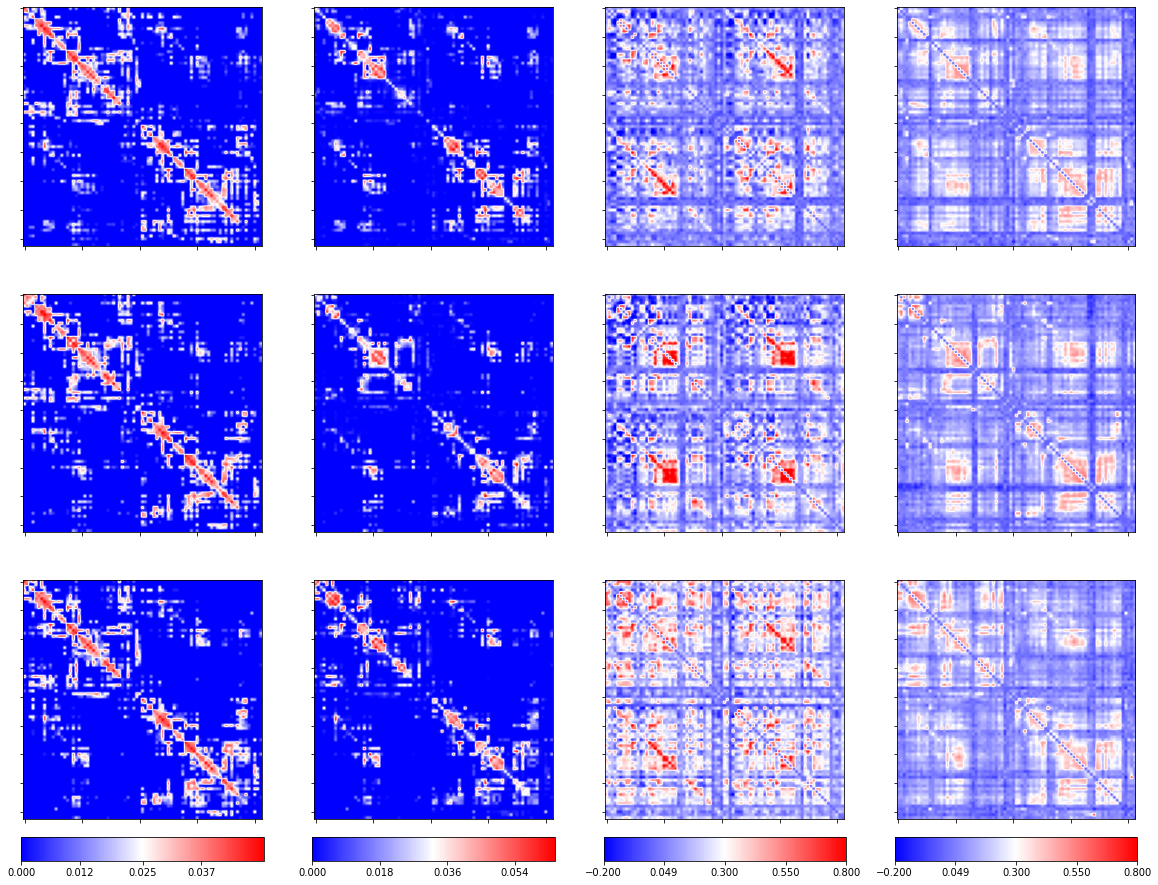

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(20,16))

vmax_ls = [0,-50,0, 0]
vmin_ls = [1,50,1, 1]
delta= np.array([0,0,0,0,-0.001])
i = 0
for sub in  ['562446', '257542', '154936']:
    if i < 4:
        if HCP_sc[sub].max() > vmax_ls[0]:
            vmax_ls[0] = HCP_sc[sub].max()
        if HCP_sc_mod[sub].max() > vmax_ls[1]:
            
            vmax_ls[1] = HCP_sc_mod[sub].max()
        if (np.corrcoef(HCP_ts[sub].T)- np.diag(np.diag(np.corrcoef(HCP_ts[sub].T)))).max() > vmax_ls[2]:
            vmax_ls[2] = (np.corrcoef(HCP_ts[sub].T)- np.diag(np.diag(np.corrcoef(HCP_ts[sub].T)))).max()
        if (np.corrcoef(HCP_ts_test[sub])- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub])))).max() > vmax_ls[3]:
            vmax_ls[3] = (np.corrcoef(HCP_ts_test[sub])- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub])))).max()
        if HCP_sc[sub].min() < vmin_ls[0]:
            vmin_ls[0] = HCP_sc[sub].min()
        if HCP_sc_mod[sub].min() < vmin_ls[1]:
            
            vmin_ls[1] = HCP_sc_mod[sub].min()
        if (np.corrcoef(HCP_ts[sub].T)- np.diag(np.diag(np.corrcoef(HCP_ts[sub].T)))).min() < vmin_ls[2]:
            vmin_ls[2] = (np.corrcoef(HCP_ts[sub].T)- np.diag(np.diag(np.corrcoef(HCP_ts[sub].T)))).min()
        if(np.corrcoef(HCP_ts_test[sub])- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub])))).min() < vmin_ls[3]:
            vmin_ls[3] = (np.corrcoef(HCP_ts_test[sub])- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub])))).min()
        i += 1
i_st = 0
i = 0
delta = np.array([0.001,0,0,0,0.0])
for sub in ['562446', '257542', '154936'] :
    if (i > i_st-1 ) and (i < i_st + 3):
        im0 = ax[i-i_st,0].imshow(HCP_sc[sub], cmap='bwr')
        sc_mod = HCP_sc_mod[sub]
        sc = HCP_sc[sub]
        
        im1 = ax[i-i_st,1].imshow(sc_mod, cmap='bwr')
        im2 = ax[i-i_st,2].imshow(np.corrcoef((HCP_ts[sub]).T)-np.diag(np.diag(np.corrcoef((HCP_ts[sub]).T))), cmap='bwr', vmax = 0.8, vmin=-0.2) #-HCP_ts_test[sub].mean(0))- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub]-HCP_ts_test[sub].mean(0))))
        im3 = ax[i-i_st,3].imshow(np.corrcoef(HCP_ts_test[sub])-np.diag(np.diag(np.corrcoef(HCP_ts_test[sub]))), cmap='bwr', vmax= 0.8, vmin=-0.2)#-HCP_ts_test[sub].mean(0))- np.diag(np.diag(np.corrcoef(HCP_ts_test[sub]-HCP_ts_test[sub].mean(0)))
        #ax[i-i_st,0].set_title('s'+sub +': empirical SC', fontsize=20)
        ax[i-i_st,0].set_xticklabels([])
        ax[i-i_st,0].set_yticklabels([])
        #ax[i-i_st,1].set_title('s'+sub +': modified SC', fontsize=20)
        ax[i-i_st,1].set_xticklabels([])
        ax[i-i_st,1].set_yticklabels([])
        #ax[i,0].tick_params(axis='y', labelsize=15)
        #ax[i-i_st,2].set_title('s'+sub +': empirical FC', fontsize=20)
        ax[i-i_st,2].set_xticklabels([])
        ax[i-i_st,2].set_yticklabels([])
        #ax[i,1].tick_params(axis='y', labelsize=15)
        #ax[i-i_st,3].set_title('s'+sub +' simulated FC', fontsize=20)
        ax[i-i_st,3].set_xticklabels([])
        ax[i-i_st,3].set_yticklabels([])
        #ax[i,2].tick_params(axis='y', labelsize= 15)
        i += 1
    elif i < i_st:
        i += 1
    else:
        break
        
cbar0 = fig.colorbar(im0, 
                     ax=ax.T[0], 
                     location='bottom', 
                     aspect=10, 
                     fraction=0.046, 
                     pad=0.02)

cbar1 = fig.colorbar(im1, 
                     ax=ax.T[1], 
                     location='bottom', 
                     aspect=10, 
                     fraction=0.046, 
                     pad=0.02)

cbar2 = fig.colorbar(im2, 
                     ax=ax.T[2], 
                     location='bottom', 
                     aspect=10, 
                     fraction=0.046, 
                     pad=0.02)

cbar3 = fig.colorbar(im3, 
                     ax=ax.T[3], 
                     location='bottom', 
                     aspect=10, 
                     fraction=0.046, 
                     pad=0.02)

cbar0.set_ticks(0.001*np.floor(1000*np.linspace(vmin_ls[0], vmax_ls[0], 5)))

cbar1.set_ticks(0.001*np.floor(1000*np.linspace(vmin_ls[1], vmax_ls[1], 5)))
cbar2.set_ticks(0.001*np.floor(1000*np.linspace(-0.2, 0.8, 5)))
cbar3.set_ticks(0.001*np.floor(1000*np.linspace(-0.2, 0.8, 5)))
plt.show()
# fig.savefig(base_dir+'HCP_sc_fc_bestfit_3subjects.png')

## Model parameter fitting estimation

How well do the parameters fit to the model? Test how much error there is for each parameter value that can be fit.

In [11]:
start_time = time.time()
mask = np.tril_indices(83,-1)

data_dict = {}
data_max = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []

data_max['g'] = []
data_max['gEE'] = []
data_max['gIE'] = []
data_max['gEI'] = []

para_name = ['g', 'gEE', 'gIE', 'gEI']

"""
Across the HCP test subjects, take the maximum of the absolute value of the mean of the parameter 
values identified for the model and the same for the parameter values. Append the two values and 
add them to the `data_max` dictionary for the coupling strength parameters. 
"""

for sub in HCP_para:
    
    data_max['g'].append(max(np.abs(HCP_para_idt[sub][0].mean()), np.abs(HCP_para[sub][0].mean())))
    data_max['gEE'].append(max(np.abs(HCP_para_idt[sub][1].mean()), np.abs(HCP_para[sub][1].mean())))
    data_max['gIE'].append(max(np.abs(HCP_para_idt[sub][2].mean()), np.abs(HCP_para[sub][2].mean())))
    data_max['gEI'].append(max(np.abs(HCP_para_idt[sub][3].mean()), np.abs(HCP_para[sub][3].mean())))

"""
Take these parameter values and use these maximum values to normalize the range of parameter values. 
"""
    
for sub in HCP_para:
    
    data_dict['g'].append((HCP_para_idt[sub][0].mean() - HCP_para[sub][0].mean())/max(data_max['g']))
    data_dict['gEE'].append((HCP_para_idt[sub][1].mean() - HCP_para[sub][1].mean())/max(data_max['gEE']))
    data_dict['gIE'].append((HCP_para_idt[sub][2].mean() - HCP_para[sub][2].mean())/max(data_max['gIE']))
    data_dict['gEI'].append((HCP_para_idt[sub][3].mean() - HCP_para[sub][3].mean())/max(data_max['gEI']))
    
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])

Plot the results.

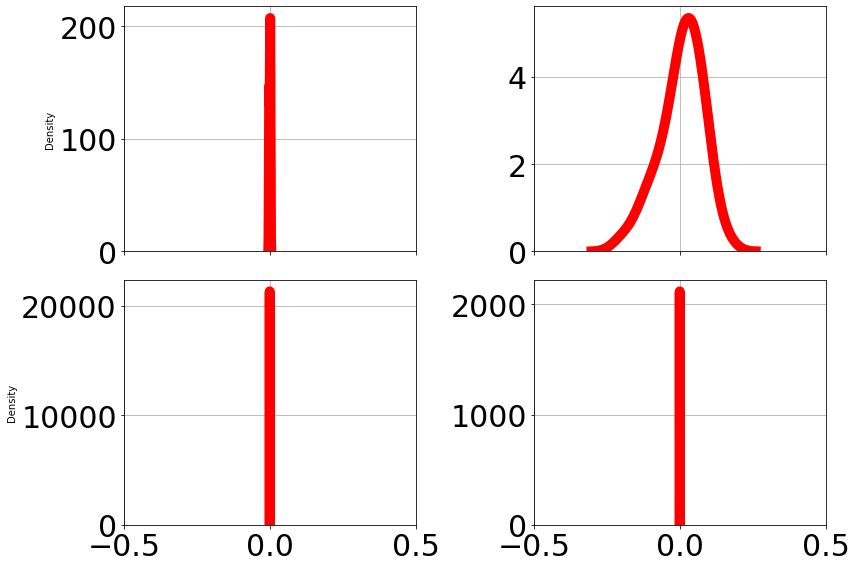

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
plt.rcParams["axes.labelsize"] = 40
for i in range(4):
    sns.kdeplot(ax=ax[i//2, i%2], data=data_dict[para_name[i]], color='r', linewidth=10)
    #ax[i//2, i%2].set_title('hist of error of ' + para_name[i] +' across subjects', fontsize = 20)
    ax[i//2, i%2].set_xlim(-0.5,0.5)
    ax[i//2, i%2].tick_params(labelsize = 30)
    ax[i//2, i%2].grid()
    if i%2 == 1:
        ax[i//2, i%2].set_ylabel('')
fig.tight_layout()
plt.show()
# fig.savefig(base_dir+'HCP_hist_modelparaserror_normalized_pt.png')

Plot the histogram of errors of parameters across subjects. 

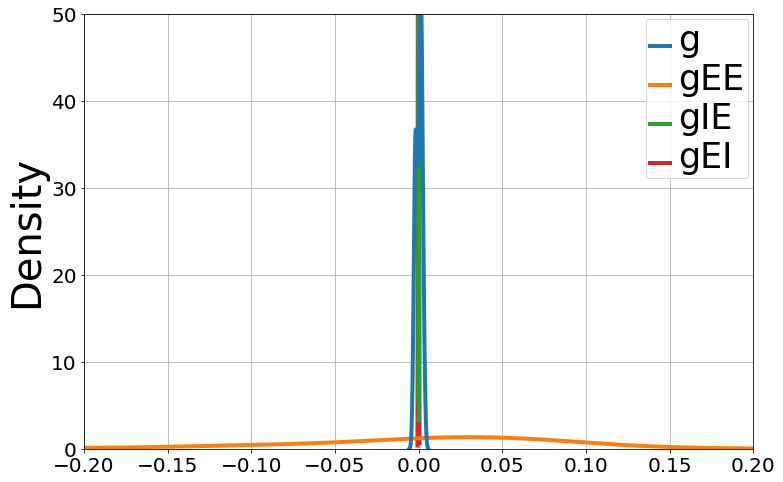

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 25
sns.kdeplot(data=pd.DataFrame(data_dict), linewidth=4)
#ax.set_title('hist of error of parameters across subjects', fontsize =25)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.2,0.2)
ax.set_ylim(0,50)
ax.grid()
plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize='50')
plt.show()
# fig.savefig(base_dir+'HCP_hist_modelparaserror_normalized_in1fig_pt.png')

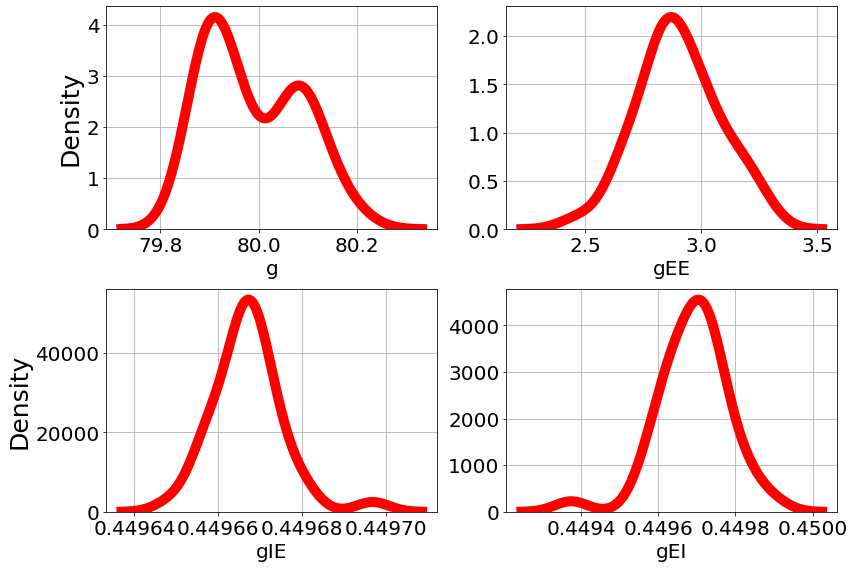

In [14]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 40
mask = np.tril_indices(83,-1)
data_dict = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
para_name = ['g', 'gEE', 'gIE', 'gEI'] #, 'cA', 'cB', 'cC']

"""
Get the mean of the parameters in the dictionary of data. 
"""

for sub in HCP_para: 
    data_dict['g'].append(HCP_para[sub][0].mean())
    data_dict['gEE'].append(HCP_para[sub][1].mean())
    data_dict['gIE'].append(HCP_para[sub][2].mean())
    data_dict['gEI'].append(HCP_para[sub][3].mean())
    """
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
    """
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])

"""
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])
"""
for i in range(4):
    sns.kdeplot(ax =ax[i//2, i%2], data= data_dict[para_name[i]], color='r', linewidth = 10)
    #ax[i//2, i%2].set_title('hist of ' + para_name[i] +' across subjects', fontsize = 20)
    ax[i//2, i%2].tick_params(labelsize = 20)
    ax[i//2, i%2].set_xlabel(para_name[i], fontsize = 20)
    ax[i//2, i%2].grid()
    if i%2 == 1:
        ax[i//2, i%2].set_ylabel('')
fig.tight_layout()  
plt.show()
#fig.savefig(base_dir+'HCP_hist_modelparas.png')

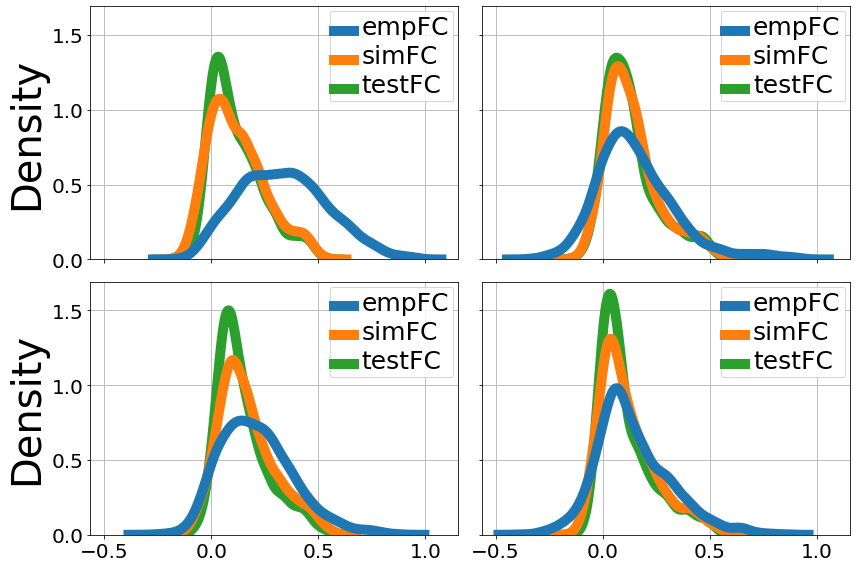

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
plt.rcParams["axes.labelsize"] = 20
i = 0
mask = np.tril_indices(83,-1)
for sub in ['198653', '257542', '154936', '280941']: 
  if i < 4:
    data_dict = {}
    data_dict['empFC'] = np.corrcoef(HCP_ts[sub].T)[mask]
    data_dict['simFC'] = np.corrcoef(HCP_ts_sim[sub][:,10:])[mask]
    data_dict['testFC'] = np.corrcoef(HCP_ts_test[sub])[mask]
    sns.kdeplot(ax =ax[i//2, i%2], data=pd.DataFrame(data_dict), linewidth=10)
    #ax[i//2, i%2].set_title('s'+sub, fontsize= 30)
    ax[i//2, i%2].tick_params(labelsize=20)
    ax[i//2, i%2].grid()
    plt.setp(ax[i//2, i%2].get_legend().get_texts(), fontsize='25')
    plt.setp(ax[i//2, i%2].get_legend().get_title(), fontsize ='40')
    if i%2 == 1:
        ax[i//2, i%2].set_ylabel('')
    i += 1
fig.tight_layout()
plt.show()
# fig.savefig(base_dir+'HCP_hist_FCs_pt.png')

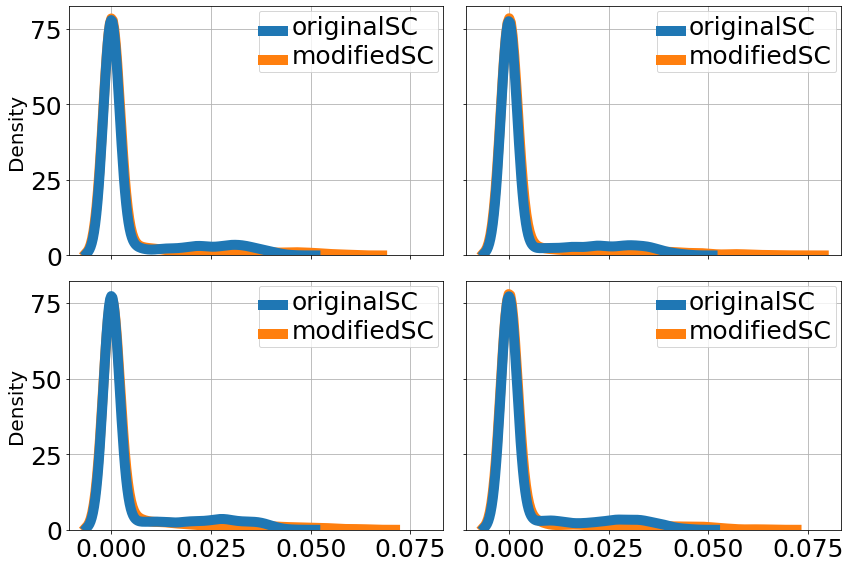

In [16]:
fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
plt.rcParams["axes.labelsize"] = 20
i = 0
mask = np.tril_indices(83, -1)
for sub in ['198653', '257542', '154936', '280941']: 
    """
    The difference between original and modified structural connectivity weights. 
    """
    if i < 4:
        data_dict = {}
        data_dict['originalSC'] = HCP_sc[sub][mask]
        sc_mod = HCP_sc_mod[sub]
        sc = HCP_sc[sub]
        w = (1 + np.tanh(sc_mod))*sc
        w_n = 0.5*(w + w.T)/np.linalg.norm(0.5*(w + w.T))
        data_dict['modifiedSC'] = sc_mod[mask]
        sns.kdeplot(ax=ax[i//2, i%2], data=pd.DataFrame(data_dict), linewidth=10)
        #ax[i//2, i%2].set_title('s'+sub, fontsize = 30)
        ax[i//2, i%2].tick_params(labelsize = 25)
        ax[i//2, i%2].grid()
        plt.setp(ax[i//2, i%2].get_legend().get_texts(), fontsize='25')
        plt.setp(ax[i//2, i%2].get_legend().get_title(), fontsize='40')

        if i%2 == 1:
            ax[i//2, i%2].set_ylabel('')
        i += 1
fig.tight_layout()
plt.show()
# fig.savefig(base_dir+'HCP_hist_SCs_pt.png')

[None, None]

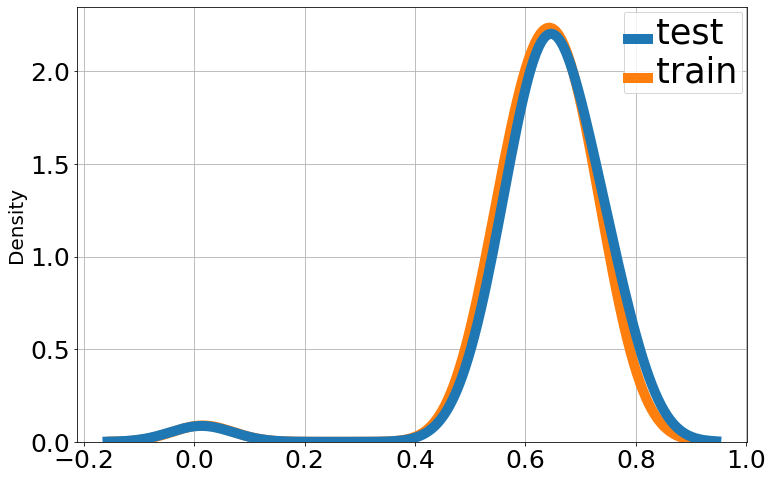

In [17]:
corr_sim = {}
corr_sim['test'] = []
corr_sim['train'] = []
mask = np.tril_indices(83,-1)
for sub in HCP_ts:
    corr_sim['train'].append(np.corrcoef(np.corrcoef(HCP_ts_sim[sub][:,10:])[mask], np.corrcoef(HCP_ts[sub].T)[mask])[0,1])
    corr_sim['test'].append(np.corrcoef(np.corrcoef(HCP_ts_test[sub])[mask], np.corrcoef(HCP_ts[sub].T)[mask])[0,1])
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 40
sns.kdeplot(data=corr_sim, linewidth=10)
#ax.set_title('hist of Pearson correlation between the fitting and empirical BOLD', fontsize=20)
ax.tick_params(labelsize=25)
ax.grid()
plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize='50')

# plt.savefig(base_dir+'HCP_hist_fittingcorrelation_pt.png')

[None, None]

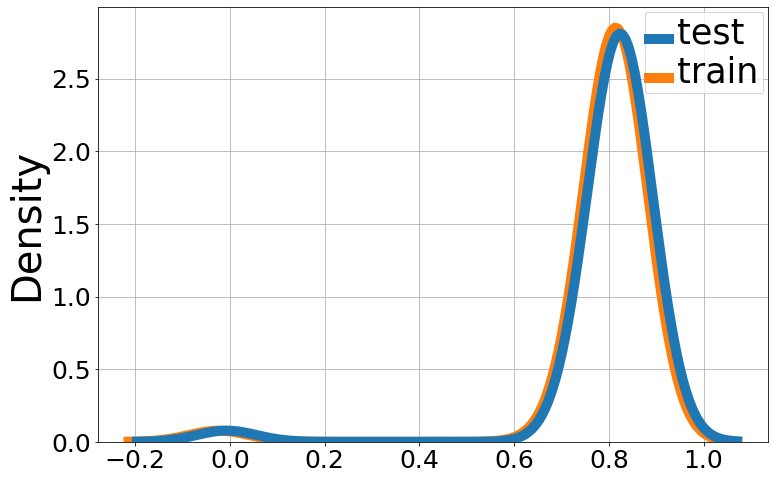

In [18]:
# cross valid for identifiability... trained on the fist 2400 and tested on the last 2400 data points
corr_sim = {}
corr_sim['test'] = []
corr_sim['train'] = []
mask = np.tril_indices(83,-1)
for sub in HCP_ts_test:
    corr_sim['train'].append(np.corrcoef(np.corrcoef(HCP_ts_sim_idt[sub][:,10:])[mask], np.corrcoef(HCP_ts_test[sub][:,:1200])[mask])[0,1])
    corr_sim['test'].append(np.corrcoef(np.corrcoef(HCP_ts_test_idt[sub])[mask], np.corrcoef(HCP_ts_test[sub][:,1200:])[mask])[0,1])
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 40
sns.kdeplot(data=corr_sim, linewidth=10)
#ax.set_title('hist of Pearson correlation between the fitting and empirical BOLD', fontsize=20)
ax.tick_params(labelsize=25)
ax.grid()
plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize='50')

## Correlation matrix of parameter fitting 

This matrix shows the correlation between the coupling strength parameters as well as the correlation coefficient on training and test data.

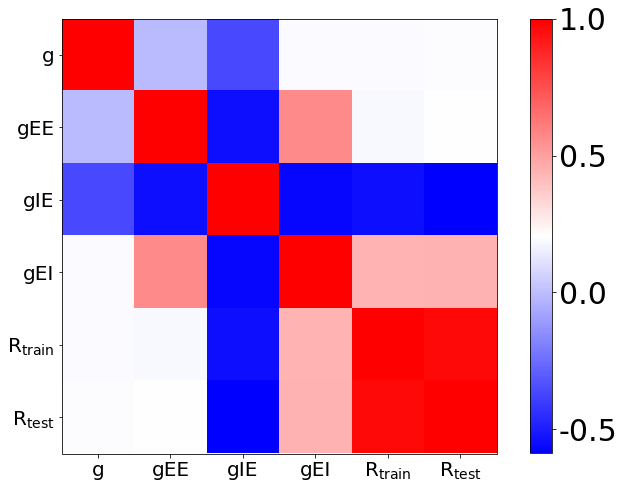

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

mask = np.tril_indices(83,-1)
data_dict = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
"""
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
"""
data_dict['$\mathregular{R_{train}}$'] = []
data_dict['$\mathregular{R_{test}}$'] = []
para_name = ['g',
             'gEE', 
             'gIE', 
             'gEI', 
             '$\mathregular{R_{train}}$', 
             '$\mathregular{R_{test}}$'] #'cA', 'cB', 'cC',

for sub in HCP_ts:
    data_dict['g'].append(HCP_para[sub][0].mean())
    data_dict['gEE'].append(HCP_para[sub][1].mean())
    data_dict['gIE'].append(HCP_para[sub][2].mean())
    data_dict['gEI'].append(HCP_para[sub][3].mean())
    """
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
    """
    data_dict['$\mathregular{R_{train}}$'].append(np.corrcoef(np.corrcoef(HCP_ts[sub].T)[mask], np.corrcoef(HCP_ts_sim[sub][:,10:])[mask])[0,1])
    data_dict['$\mathregular{R_{test}}$'].append(np.corrcoef(np.corrcoef(HCP_ts[sub].T)[mask], np.corrcoef(HCP_ts_test[sub])[mask])[0,1])
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])
"""
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])
"""
data_dict['$\mathregular{R_{train}}$'] = np.array(data_dict['$\mathregular{R_{train}}$'])
data_dict['$\mathregular{R_{test}}$'] = np.array(data_dict['$\mathregular{R_{test}}$'])

corr_paras = np.zeros((len(data_dict), len(data_dict)))
for i in range(len(data_dict)):
    for j in range(len(data_dict)):
        corr_paras[i,j] = np.corrcoef(data_dict[para_name[i]], data_dict[para_name[j]])[0,1]

im = ax.imshow(corr_paras, cmap='bwr')
ax.set_xticklabels(['0' ] + para_name, fontsize=20)
ax.set_yticklabels(['0'] + para_name, fontsize=20)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_ticks(np.linspace(-1,1,5))
cbar.set_ticklabels(np.linspace(-1,1,5))
plt.show()
# fig.savefig(base_dir + 'HCP_corr_modelparas+fit_pt.png')

In [ ]:
#@title
def get_rotation_matrix(rotation_axis, deg):
    
  '''Return rotation matrix in the x,y,or z plane'''
   
  
 
  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians
    
  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])
    


def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat

In [ ]:
def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views 
   
  This function calls plot_surface_mpl five times to give a complete 
  picture of a surface- or region-based spatial pattern. 

  As with plot_surface_mpl, this function is written so as to be 
  generally usable with neuroimaging surface-based data, and does not 
  require construction of of interaction with tvb datatype objects. 

  In order for the medial surfaces to be displayed properly, it is 
  necessary to separate the left and right hemispheres. This can be 
  done in one of two ways: 

  1. Provide single arrays for vertices, faces, data, and 
     region mappings, and addition provide arrays of indices for 
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False 
     indicating left hemisphere vertices/faces/regions, and 1/True 
     indicating right hemisphere. 

     Note: this requires that 

  2. Provide separate vertices,faces,data,and region mappings for 
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)


 
  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices
 
  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) - 
      

  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``
  
  tri_lh            : left hemisphere surface faces 
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot
 
  kwargs           : additional tripcolor kwargs; see plot_surface_mpl

 

  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths 
  # connectivity matrix. The corresponding region is 
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'}) 


  """
   

 
  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])
    
  if rm_lh is not None:                                  # Option 2 
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 

  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the 
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't 
  #  connected by the faces in tri )
  fig, ax = plt.subplots(2,3, figsize=(6,4))
  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
  # Both superior
  im =plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
  plt.subplots_adjust(left=0.0, right=.8, bottom=0.0,
                      top=.8, wspace=0, hspace=0)
  cbar_ax = fig.add_axes([0.85,0.1,0.05,0.6])
  fig.colorbar(im, cax = cbar_ax)

  #@title function for plot brain in one picture

In [ ]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
  return tc
#@title function for plotting surface

## Initialize variables

This rearranges the l2k8 indices to match the sorted aparc labels used in the MEG analysis. This is meant to convert from the aparc labels (the Lausanne 2008 parcellation, also used in Hagmann et al., 2008, "Mapping the Structural Core of Human Cerebral Cortex") to the mri_aparc2aseg parcellation scheme. 

In [ ]:
"""l2k8_to_aparc_sort_idx = np.array([22, 21, 20, 23, 18, 17, 19, 14, 24, 30, 16, 28, 10, 25, 15, 13, 29,
       32, 31,  9, 26, 33, 27,  8,  5, 12,  7,  4,  3, 11,  0,  1,  6,  2, 34, 35,
       64, 62, 63, 65, 60, 59, 61, 56, 66, 72, 58, 70, 67, 71, 52, 57, 55,
       74, 73, 51, 68, 75, 69, 50, 47, 54, 49, 46, 53, 42, 43, 45, 48, 44, 76,77])"""

l2k8_to_aparc_sort_idx = np.array([82, 30, 12,  8, 82, 20, 26, 24, 18, 28, 14, 22,  0, 23,  3, 29, 25,
       10,  5,  1,  4, 21, 15, 13,  9, 19, 11,  6,  7, 17, 31, 16,  2, 27,
       32, 33, 82, 71, 53, 49, 82, 61, 67, 65, 59, 69, 55, 63, 41, 64, 44,
       70, 66, 51, 46, 42, 45, 62, 56, 54, 50, 60, 52, 47, 48, 58, 72, 57,
       43, 68, 73, 74])

## Load SC data

Load the data of the structural connectivity weights and tract lengths. 

In [ ]:
# Load the data from the .npy files.
l2k8_w = np.loadtxt('../data/HCP/hcp_grpavg_l2k8_sc33_weights.npy') # structural connectivity weights 
l2k8_tl = np.loadtxt('../data/HCP/hcp_grpavg_l2k8_sc33_tractlengths.npy') # tract lengths between regions

# Convert the files to pandas DataFrames. 
df_l2k8_w = pd.DataFrame(l2k8_w) 
df_l2k8_tl = pd.DataFrame(l2k8_tl)

df_l2k8_w *= ((np.eye(83)*-1) + 1) # Multiply by a matrix of all 1s with 0s on the diagonal.
df_l2k8_wlog = np.log1p(df_l2k8_w) # Obtain log(1+x) for the weights x for the 83 x 83 matrix of regions.

df_l2k8_wlog_divmax = df_l2k8_wlog.copy() # Copy the DataFrame. 
df_l2k8_wlog_divmax /= df_l2k8_wlog.max() # Divide the DataFrame by its maximum amount to normalize it.

_df_w = df_l2k8_wlog_divmax.copy()
_df_w[_df_w<0.2] = 0

In [ ]:
# Use these regions of the brain as focal nodes in representing the DMN. 

l2k8_lV1_idx = 21 # pericalcarine
l2k8_lM1_idx = 24 # precentral
l2k8_lA1_idx = 30 # superior temporal
l2k8_lS1_idx = 22 # postcentral
l2k8_lDLPFC_idx = 12 # lateral orbitofrontal
l2k8_lVLPFC_idx = 19 # pars orbitalis

focal_nodes = [l2k8_lV1_idx,
               l2k8_lA1_idx,
               l2k8_lM1_idx,
               l2k8_lS1_idx,
               l2k8_lDLPFC_idx,
               l2k8_lVLPFC_idx]

focal_node_names = ['lV1',
                    'lA1',
                    'lM1',
                    'lS1',
                    'lDLPFC',
                    'lVLPFC']

In [ ]:
# Various surface representations for left and right hemisphere
# With the inflated surface representations, you can fully see the sulci. 
lhi_file = '../data/HCP/fsav5_lh.inflated'  
rhi_file = '../data/HCP/fsav5_rh.inflated'

# The pial surface is used to calculate cortical gray matter volume and 
# should accurately follow the boundary between the gray matter and the Cerebrospinal fluid (CSF).
lhp_file = '../data/HCP/fsav5_lh.pial' 
rhp_file = '../data/HCP/fsav5_rh.pial'

# Annotatation files for the parcellated regions
lh_annot_file = '../data/HCP/fsav5_lh.aparc.annot' 
rh_annot_file = '../data/HCP/fsav5_rh.aparc.annot' 

In [ ]:
# Return the vertex coordinates (rhi_vtx) and mesh triangles (rhi_tri) for the files
lhi_vtx, lhi_tri = nib.freesurfer.read_geometry(lhi_file)
rhi_vtx, rhi_tri = nib.freesurfer.read_geometry(rhi_file) 

lhp_vtx, lhp_tri = nib.freesurfer.read_geometry(lhp_file) 
rhp_vtx, rhp_tri = nib.freesurfer.read_geometry(rhp_file) 

lh_annot = nib.freesurfer.read_annot(lh_annot_file) 
rh_annot = nib.freesurfer.read_annot(rh_annot_file) 

vtx_l2k8_lh = lhp_vtx
tri_l2k8_lh = lhp_tri
#vtx_l2k8_lh = lhi_vtx
#tri_l2k8_lh = lhi_tri
rm_l2k8_lh = lh_annot[0]

vtx_l2k8_rh = rhp_vtx
tri_l2k8_rh = rhp_tri
#vtx_l2k8_rh = rhi_vtx
#tri_l2k8_rh = rhi_tri
rm_l2k8_rh = rh_annot[0]

# Concatenate them together for the regions.
vtx_l2k8_lhrh = np.concatenate([vtx_l2k8_lh,vtx_l2k8_rh], axis=0)
tri_l2k8_lhrh = np.concatenate([tri_l2k8_lh,tri_l2k8_rh+10242], axis=0)

rm_l2k8_rh_p1 = rm_l2k8_rh + 36
rm_l2k8_rh_p1[rm_l2k8_rh == 0] = 0

rm_l2k8_lhrh = np.concatenate([rm_l2k8_lh, rm_l2k8_rh_p1], axis=0)
rm_l2k8_lhrh

hemi = np.ones_like(rm_l2k8_lhrh)
hemi[:10242] = 0
hemi

## Plot

Generate the plots of the default mode network structure.

In [ ]:
# functional connectivity values across regions for three different subjects 
# The number coreresponds to the different columns of the FC (e.g., fc_54 has the 54th column).
fc_54 = np.array([0.07682509, -0.02128439, -0.03384062,  0.05320176,  0.05471503,
        0.13934857,  0.20621781,  0.17206639,  0.10512446,  0.10776393,
        0.29780534,  0.14799411,  0.30186789,  0.43196902,  0.33156828,
        0.25412462,  0.30922221,  0.12608491,  0.27343265,  0.41269201,
        0.25245327,  0.09809735, -0.11438562,  0.20858446,  0.07015369,
        0.08555236,  0.08659411,  0.04477133,  0.08317634,  0.11445271,
        0.12312393,  0.16196342,  0.06828829,  0.26020704,  0.12544554,
        0.05920674,  0.03225544,  0.01331936, -0.0215654 ,  0.07715058,
       -0.0389014 ,  0.17158385,  0.0094781 ,  0.02607858,  0.11923761,
        0.06269088,  0.10788386,  0.36012597,  0.22229945,  0.21825426,
        0.02970901,  0.24230718,  0.15896073,  0.40808317,  1.        ,
        0.33747972,  0.23850011,  0.30159616,  0.1130841 ,  0.2969263 ,
        0.47867023,  0.19959395,  0.06715806, -0.09413906,  0.20176679,
        0.10768835,  0.02944969,  0.04499624, -0.03408385,  0.17570769,
        0.16808477,  0.06259806,  0.26563371,  0.14068841,  0.27621275,
        0.1306482 ,  0.09807702,  0.09850341,  0.05073915,  0.03550151,
        0.17014859,  0.06636479,  0.17870341])

fc_60 = np.array([0.15569094, -0.03885425,  0.04890683,  0.16171774,  0.04725465,
        0.07753457,  0.30875898,  0.35187976,  0.34662134,  0.09912189,
        0.29338462,  0.25739101,  0.17445902,  0.4670589 ,  0.62694002,
        0.25998084,  0.25925487,  0.33025557,  0.62163083,  0.8369526 ,
        0.52574254,  0.31510396,  0.06566058,  0.44301474,  0.27148304,
        0.30111694,  0.08374708,  0.11905168,  0.13817447,  0.35589242,
        0.20325078,  0.28584166,  0.13142756,  0.2040255 ,  0.27938807,
        0.11800877,  0.03426762,  0.03599968,  0.01689927,  0.24260188,
       -0.03815829,  0.19310196,  0.03499076,  0.10427147,  0.13123463,
        0.11359923,  0.2292006 ,  0.51829568,  0.3945326 ,  0.47134833,
        0.14234746,  0.17401509,  0.24885599,  0.29500217,  0.47867023,
        0.62890929,  0.34624069,  0.36416877,  0.3573325 ,  0.69456097,
        1.        ,  0.45229606,  0.34654782,  0.12841021,  0.47623741,
        0.23457237,  0.06286334,  0.02768237,  0.00291156,  0.27546106,
        0.37390449,  0.29662638,  0.3605275 ,  0.22705125,  0.26378275,
        0.22736693,  0.2490869 ,  0.03850265,  0.0448428 ,  0.07056435,
        0.13632041,  0.06124779,  0.13272672])

fc_48 = np.array([ 0.08348805,  0.25433363,  0.30718973,  0.21778039, -0.03452652,
       -0.07191728,  0.04859293,  0.58070912,  0.3228884 ,  0.03022416,
        0.096414  ,  0.2067467 ,  0.02934248,  0.11758467,  0.3395558 ,
        0.2618392 , -0.04729804,  0.02403979,  0.33068409,  0.18542544,
        0.11157786,  0.24558548,  0.35921583,  0.14047045,  0.16072442,
        0.08725231,  0.04247384,  0.21984861,  0.15750137,  0.49704743,
        0.38107799,  0.18360744,  0.13072013,  0.03044336,  0.25038236,
        0.21535622,  0.04945266,  0.09180092,  0.07482232,  0.19016411,
       -0.01817344,  0.30486544,  0.58977128,  0.33755094,  0.19382802,
        0.33391812,  0.38968696,  0.47185658,  1.        ,  0.74660754,
        0.25389967,  0.11339373,  0.30413138,  0.18101733,  0.22229945,
        0.48579973,  0.29879378,  0.14413303,  0.12710287,  0.61299693,
        0.3945326 ,  0.03012108,  0.25349449,  0.36321952,  0.1842467 ,
        0.09006558,  0.00976703,  0.01410019,  0.08918964,  0.24576006,
        0.72460302,  0.25165407,  0.31029377,  0.155622  ,  0.07071528,
        0.26798855,  0.34361951,  0.15074631,  0.07711461,  0.13811093,
        0.20971265,  0.03274206,  0.08477825])

# Set the seed for the seed-based functional connectivity analysis. 
seed = np.zeros_like(fc_48)
seed[60] = 1
_cm = 'RdBu_r'

# keywords
kws = {'edgecolors': 'k', 
       'cmap': _cm, # 'Reds_r', #RdBu_r', # jet', 
       'vmax': 0.5,
       'vmin': -.3, 
       'alpha': None, 
       'linewidth': 0.05}

plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,
                    tri=tri_l2k8_lhrh,
                    hemi=hemi,
                    reorient='fs',
                    data=fc_60[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh],
                    shade_kwargs=kws)
"""_cm = 'BuGn'
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
       'vmax': 1.0,'vmin': 0.0, 'alpha': 0.15, 'linewidth': 0.05}
mask = np.array([False]*40960)
mask[:vtx_l2k8_lhrh.shape[0]]= seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh] == 1
mask1 = seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh] == 1
plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,tri=tri_l2k8_lhrh,hemi=hemi,reorient='fs',data=seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh],
                    shade_kwargs=kws)    """      

In [ ]:
fc_test_54 = np.array([4.04483037e-02,  7.32430791e-02,  7.76209493e-02, -4.46576574e-02,
        6.90320864e-02,  6.08216248e-02,  1.25866896e-01,  1.48259337e-01,
        1.46379082e-01,  1.60607085e-01,  1.99941445e-01, -4.73537989e-02,
        9.32955181e-02,  1.84146202e-01,  1.12089813e-01,  1.58828217e-01,
        1.37430776e-01,  3.38672182e-02,  8.48897343e-02,  1.80693377e-01,
        3.68792057e-02, -1.50098567e-02,  3.20046130e-02,  1.00762267e-02,
        1.56791288e-02,  2.76290084e-02, -3.96479495e-02,  2.80856785e-02,
        3.91929104e-02,  4.77790081e-02,  4.41821994e-02,  6.01223904e-02,
        5.10560110e-02,  7.76196128e-02,  1.12436866e-01,  2.73838335e-02,
       -2.39388323e-02,  1.71982611e-02,  7.29186160e-02,  5.29034320e-02,
       -1.99933514e-03,  7.06724821e-02,  5.93341413e-02, -4.13728002e-02,
        1.29869528e-04,  1.23697792e-01,  1.43169035e-01,  2.10767740e-01,
        3.11019690e-01,  1.38353247e-01,  1.86178990e-01,  2.70765146e-01,
       -9.97468529e-03,  3.78946661e-01,  1.00000000e+00,  3.15421661e-01,
        1.52251462e-01,  1.33510163e-01,  1.12895918e-01,  1.14309818e-01,
        2.51496899e-01,  4.27383293e-02,  4.84373107e-02,  4.49691775e-02,
        6.54305540e-02,  6.93010133e-02, -3.49596325e-02, -1.16978796e-02,
       -5.19326833e-02,  1.19297520e-01,  1.13479555e-01,  9.82750559e-02,
        1.37192609e-01,  1.10936182e-01,  1.36305410e-01,  1.35283865e-01,
        1.46130802e-01,  1.08109444e-01,  2.04031992e-02, -1.04834287e-02,
       -5.35527088e-02,  3.55320361e-02,  5.05661223e-02])

fc_test_13 = np.array([ 0.02064446, -0.02125758,  0.06787312, -0.05500374, -0.03885027,
       -0.01193319,  0.02590079,  0.07862877,  0.11140791,  0.12894951,
        0.29816439, -0.07257691,  0.39432721,  1.        ,  0.41285587,
        0.15905054,  0.02590495,  0.02414737,  0.16389443,  0.33678748,
        0.06684584,  0.02343256,  0.01415101, -0.00517585,  0.0300626 ,
        0.14180168,  0.04087309, -0.02108286,  0.01249072,  0.02652301,
        0.0147603 ,  0.05418977,  0.01977914,  0.03116899,  0.03394   ,
        0.0515946 , -0.0622778 , -0.03677459,  0.02683279,  0.09717596,
        0.04846726,  0.0334019 ,  0.06863676, -0.02671001, -0.04969303,
        0.04434678,  0.0240701 ,  0.05507989,  0.09096978,  0.08247514,
        0.10845567,  0.22910861, -0.04563424,  0.13561862,  0.1841462 ,
        0.16418864,  0.11336982,  0.11471379,  0.11565096,  0.05493549,
        0.27033029,  0.01242047,  0.03619441,  0.08456932,  0.05367578,
        0.10041786, -0.04090774, -0.01034624, -0.03077638,  0.08534603,
        0.06689338,  0.06317927,  0.07676879,  0.11862627,  0.05053353,
        0.10158778,  0.09397584,  0.05032458,  0.0745082 ,  0.04716247,
        0.08466447, -0.05279958,  0.03736607])

fc_test_60 = np.array([3.51703550e-02,  5.18501633e-02,  3.00072240e-02, -3.22250993e-03,
        5.70771272e-03,  3.04967810e-02,  6.09221308e-02,  1.09301758e-01,
        1.10533317e-01,  1.28118958e-01,  2.10016752e-01,  1.09933921e-03,
        9.57229525e-02,  2.70330287e-01,  1.90774291e-01,  1.47761080e-01,
        8.97752877e-02,  1.11693599e-01,  1.95514360e-01,  2.72475220e-01,
        1.00020912e-01,  6.70112479e-02,  6.97584082e-02,  7.93095470e-02,
        8.93715930e-02,  7.42034261e-02,  3.39152899e-02, -4.49641276e-02,
       -2.76792903e-02,  2.70008066e-02, -4.64044487e-03,  7.18338669e-02,
        2.04857838e-03,  8.14713997e-02,  1.17725733e-01,  7.42598533e-02,
        2.96991318e-03, -5.39451022e-02,  2.48211990e-02,  7.97761141e-02,
        1.85885648e-02,  1.56141833e-01,  3.34977809e-02, -3.00353457e-02,
       -1.62362070e-02,  8.00848864e-02,  1.34135085e-01,  1.40980153e-01,
        1.77252780e-01,  1.22131104e-01,  2.10072865e-01,  2.10706170e-01,
       -7.68060410e-04,  1.37570662e-01,  2.51496899e-01,  2.69339188e-01,
        2.11895067e-01,  1.73590178e-01,  2.42313753e-01,  2.07098915e-01,
        1.00000000e+00,  8.07081133e-02,  1.00150620e-01,  8.85262622e-02,
        9.18910872e-02,  1.83301361e-01, -1.60720267e-02,  3.92561061e-02,
        1.93154903e-03,  2.41607488e-01,  2.17235434e-01,  1.30866821e-01,
        2.47044743e-01,  2.56881848e-01,  1.50520001e-01,  2.11369632e-01,
        1.62973354e-01,  1.44820176e-01,  2.40272233e-02,  4.40490309e-02,
        3.92930927e-02, -4.07958819e-02,  4.43558957e-02])

fc_test_48 = np.array([ 0.04456317,  0.08430425,  0.10337379, -0.0751953 ,  0.09872982,
        0.1291111 ,  0.18314354,  0.20767963,  0.23303186,  0.19998463,
        0.14810478, -0.05109569,  0.05073159,  0.09096978,  0.08419494,
        0.17615717,  0.16614261,  0.0196335 ,  0.09354732,  0.08995714,
        0.05359471, -0.00912246,  0.03514153,  0.02057001,  0.02612656,
        0.01342597, -0.0294798 ,  0.00696833,  0.02931964,  0.03325134,
        0.07043438,  0.0502618 ,  0.02825642,  0.18071165,  0.18340093,
        0.06189989, -0.00533773,  0.06097923,  0.10050126,  0.06412034,
        0.01178386,  0.17734297,  0.06325622, -0.02823774, -0.02826472,
        0.23305105,  0.33101713,  0.32282376,  1.        ,  0.31766683,
        0.28207603,  0.209288  ,  0.00738726,  0.27140204,  0.31101969,
        0.22895553,  0.2234192 ,  0.18360893,  0.16395947,  0.21453826,
        0.17725278,  0.0341468 ,  0.03666224,  0.00832946,  0.05212808,
        0.07890769,  0.01180786, -0.01867186, -0.04819648,  0.11294647,
        0.16827467,  0.14320286,  0.16911658,  0.13737125,  0.19928486,
        0.21347781,  0.14709652,  0.16063771,  0.02247446,  0.04255669,
       -0.00888587,  0.04339403,  0.07802365])

fc_test_41 = np.array([ 2.91574121e-02,  3.99662172e-02,  9.14379959e-02, -8.00334527e-03,
       -2.50339264e-02,  3.63609413e-02,  1.06375335e-01,  1.06307706e-01,
        1.41449230e-01,  1.52185927e-01,  1.40082493e-01,  5.44236473e-03,
       -2.84602123e-03,  3.34019030e-02,  7.24177217e-02,  1.29194284e-01,
        1.10487105e-01,  9.90362175e-02,  1.04988485e-01,  1.12635543e-01,
        1.02215036e-01,  3.63280972e-02,  9.13308055e-02,  6.25911165e-02,
        6.41443914e-02,  5.56257774e-02,  4.64617068e-02, -1.15959055e-02,
        9.60144121e-03,  5.03256381e-02,  3.93803611e-03,  5.98747396e-02,
       -3.76220011e-02,  6.67289208e-02,  1.50632776e-01,  5.85915414e-02,
       -5.79427852e-03, -2.67941385e-02,  2.60525511e-02,  8.43785417e-02,
        6.25090275e-02,  1.00000000e+00,  8.24955180e-02, -3.07733096e-02,
        3.37654868e-02,  1.69057126e-01,  1.98151129e-01,  2.99425215e-01,
        1.77342974e-01,  1.43791454e-01,  1.87007384e-01,  1.55162276e-01,
        2.97501823e-03,  1.24536132e-01,  7.06724821e-02,  1.09327160e-01,
        2.14722698e-01,  1.89543923e-01,  1.55433207e-01,  2.17070757e-01,
        1.56141833e-01,  7.86344152e-02,  8.39345856e-02,  9.96740939e-02,
        7.45054762e-02,  1.31522853e-01,  4.30021043e-02, -1.37114672e-02,
       -3.84809861e-04,  1.87042770e-01,  2.42837501e-01,  1.73869281e-01,
        2.42828040e-01,  1.65126795e-01,  3.06438319e-01,  2.48172135e-01,
        2.74101333e-01,  2.87125048e-01,  3.19166679e-03,  1.65886750e-02,
        3.04314795e-02,  3.21617761e-02,  4.86736314e-03])

seed = np.zeros_like(fc_48)
seed[48] = 1
_cm = 'RdBu_r'
kws = {'edgecolors': 'k', 
       'cmap': _cm, # 'Reds_r', #RdBu_r', # jet', 
       'vmax': 0.35,
       'vmin': -.2, 
       'alpha': None, 
       'linewidth': 0.05}

plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,
                    tri=tri_l2k8_lhrh,
                    hemi=hemi,
                    reorient='fs',
                    data=fc_test_48[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh],
                    shade_kwargs=kws)          
"""_cm = 'BuGn'
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
       'vmax': 1.0,'vmin': 0.0, 'alpha': 0.15, 'linewidth': 0.05}
mask = np.array([False]*40960)
mask[:vtx_l2k8_lhrh.shape[0]]= seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh] == 1
mask1 = seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh] == 1
plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,tri=tri_l2k8_lhrh,hemi=hemi,reorient='fs',data=seed[l2k8_to_aparc_sort_idx][rm_l2k8_lhrh],
                    shade_kwargs=kws)"""

In [ ]:
end_time =  time.time()
print('Running time is  {0} \'s'.format(end_time - start_time ))